In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [ ]:
#Idée générale : on va reprendre le graphe stat desc pour identifier la source de pollution principale dans le Finistère

In [2]:
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

In [4]:
data_pollution = pd.read_csv("base_pollution.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [5]:
pollution_group_dep = pd.read_csv("pollution_group_dep.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [6]:
pollution_group_reg = pd.read_csv("pollution_group_reg.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [ ]:
x = input("Entrer un numéro de département (mettre un 0 devant si c'est un chiffre) : ")

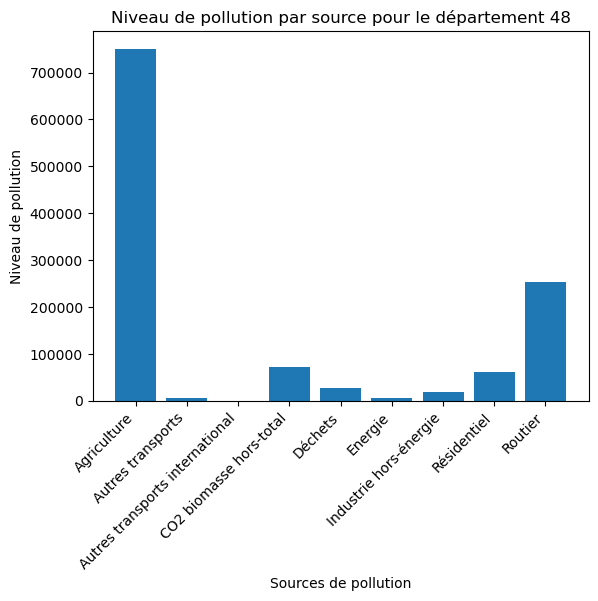

In [42]:
# Sélectionnez les données pour le département x
pollution_dep_91 = pollution_group_dep[pollution_group_dep['DEP'] == x]

# Sélectionnez les colonnes correspondant aux sources de pollution
sources_pollution = pollution_dep_91.columns[1:10]

# Créez un diagramme en barres
plt.bar(sources_pollution, pollution_dep_91.iloc[0, 1:10])
plt.xlabel('Sources de pollution')
plt.ylabel('Niveau de pollution')
plt.title('Niveau de pollution par source pour le département {}'.format(x))
plt.xticks(rotation=45, ha='right')

plt.show()


#La source de pollution principale dans le Finistère est l'agriculture 

In [30]:
#Pa rapport aux autres histogramme ici on va prendre pathoniv2 pour les dummies 
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape
base_grande = base_grande.dropna()
base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv2'], dtype='int')


liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv1 = liste_bis

liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age

KeyboardInterrupt: 

In [11]:
#On supprime les espaces dans le noms des colonnes 
base_grande.columns = base_grande.columns.str.replace(' ', '_')

In [16]:
#On recréer un base similaire auxx base de statdesc
model_prostate = base_grande[['dept', 'classe_age','indicatrice__Cancer_de_la_prostate','sexe','region']]
model_prostate

,dept,classe_age,indicatrice__Cancer_de_la_prostate,sexe,region
0,971,82.0,0,1.0,1
1,973,82.0,0,1.0,3
2,999,82.0,0,1.0,4
3,999,82.0,0,1.0,6
4,75,82.0,0,1.0,11
...,...,...,...,...,...
4057196,34,22.0,0,9.0,76
4057197,46,22.0,0,9.0,76
4057198,81,22.0,0,9.0,76
4057199,82,22.0,0,9.0,76


In [17]:
compte_dept_29 = 0

for index, row in model_prostate.iterrows():
    if row['dept'] == '29':
        compte_dept_29 += 1

print("Nombre d'individus avec dept=='29' :", compte_dept_29)

#Ce code nous donne le nombre d'individus en provenance du Finistère à savoir 18467

Nombre d'individus avec dept=='29' : 18467


In [18]:
compte_prostate = 0

# Supposons que model_prostate soit votre DataFrame
# Remplacez-le par le nom de votre DataFrame
for index, row in model_prostate.iterrows():
    if row['dept'] == '29' and row['indicatrice__Cancer_de_la_prostate'] == 1:
        compte_prostate += 1

print("Nombre d'individus avec dept=='29' et indicatrice__Cancer_de_la_prostate==1 :", compte_prostate)

#Ce code nous donne le nombre d'individus en provenance du Finistère et qui sont atteints d'un cancer de la prostate à savoir 320

#Oa donc 320/18467*100 soit environ 0,17% de cancer de la prostate parmi les observés résidants dans le Finistère 


Nombre d'individus avec dept=='29' et indicatrice__Cancer_de_la_prostate==1 : 320


In [22]:
#On prend la liste des départements observés afin de généralisé notre démarche
valeurs_uniques = model_prostate['dept'].unique()
print(valeurs_uniques)

['971' '973' '999' '75' '94' '95' '25' '58' '27' '61' '62' '80' '54' '67'
 '53' '33' '40' '47' '86' '34' '46' '48' '65' '82' '09' '01' '63' '69'
 '74' '2B' '974' '976' '91' '92' '28' '37' '41' '45' '89' '90' '14' '10'
 '51' '52' '57' '08' '49' '72' '85' '35' '56' '24' '64' '12' '66' '03'
 '38' '42' '06' '84' '78' '18' '21' '02' '68' '17' '23' '79' '87' '30'
 '31' '32' '15' '13' '83' '93' '36' '70' '55' '44' '16' '19' '11' '43'
 '04' '05' '2A' '972' '77' '88' '29' '26' '07' '39' '50' '59' '60' '76'
 '81' '71' '73' '22']


In [26]:
import pandas as pd

# Supposons que 'model_prostate' est votre DataFrame
# et 'dept' est la colonne représentant les départements

# Grouper par département et compter le nombre total d'individus et le nombre de cas de cancer de la prostate
resultats = model_prostate.groupby('dept')['indicatrice__Cancer_de_la_prostate'].agg(['count', 'sum'])

# Renommer les colonnes
resultats.columns = ['pop_i', 'pop_i2']

# Remplacer les valeurs manquantes par 0
resultats['pop_i2'].fillna(0, inplace=True)

# Initialiser la variable pour la moyenne
moyenne_totale = 0

# Calculer le pourcentage de cancer de la prostate par département et afficher les résultats
for index, row in resultats.iterrows():
    if row['pop_i'] != 0:
        pourcentage_cancer = (row['pop_i2'] / row['pop_i']) * 100
        moyenne_totale += pourcentage_cancer
        print(f"Il y a {pourcentage_cancer:.2f}% de cancer de la prostate dans le département {index}.")
    else:
        print(f"Aucun individu dans le département {index} dans votre DataFrame.")

# Calculer la moyenne totale
if len(resultats) > 0:
    moyenne_totale /= len(resultats)
    print(f"\nLa moyenne totale des pourcentages de cancer de la prostate est {moyenne_totale:.2f}%.")
else:
    print("\nAucun résultat à moyenner, car tous les départements ont une population de 0.")


Il y a 1.76% de cancer de la prostate dans le département 01.
Il y a 1.78% de cancer de la prostate dans le département 02.
Il y a 1.88% de cancer de la prostate dans le département 03.
Il y a 1.89% de cancer de la prostate dans le département 04.
Il y a 1.97% de cancer de la prostate dans le département 05.
Il y a 1.69% de cancer de la prostate dans le département 06.
Il y a 1.88% de cancer de la prostate dans le département 07.
Il y a 1.73% de cancer de la prostate dans le département 08.
Il y a 2.01% de cancer de la prostate dans le département 09.
Il y a 1.86% de cancer de la prostate dans le département 10.
Il y a 1.81% de cancer de la prostate dans le département 11.
Il y a 1.99% de cancer de la prostate dans le département 12.
Il y a 1.65% de cancer de la prostate dans le département 13.
Il y a 1.82% de cancer de la prostate dans le département 14.
Il y a 2.03% de cancer de la prostate dans le département 15.
Il y a 1.84% de cancer de la prostate dans le département 16.
Il y a 1

In [ ]:
#On observe donc :
#Des résultats inférieurs à la moyenne dans le Finistère
#Des résultats très élevés dans les outre mer
#Des résultats au dessus de 2% pour le Gers(32), la Creuse(23), et l'Ariège(09) le Lot(46) et la Lozère(48) pour la France métropolitaine

In [ ]:
#En observant l'histogramme des souces de pollution pour ces différents départements, on remarque que :
#L'agriculture est la source principale de pollution
